In [ ]:
!pip install -q boto3
!pip install -q xgboost==0.90

In [3]:
import boto3
import sagemaker
import pandas as pd

sess   = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name='sagemaker', region_name=region)

# Copy the datasets from S3 to this notebook instance

In [4]:
# $S3_BUCKET/feature-store/amazon-reviews/balanced-tfidf-without-header/data.csv

prefix_train = 'feature-store/amazon-reviews/csv/balanced-tfidf-without-header/train'
prefix_validation = 'feature-store/amazon-reviews/csv/balanced-tfidf-without-header/validation'
prefix_test = 'feature-store/amazon-reviews/csv/balanced-tfidf-without-header/test'

balanced_tfidf_without_header_train_path = './{}'.format(prefix_train)
balanced_tfidf_without_header_validation_path = './{}'.format(prefix_validation)
balanced_tfidf_without_header_test_path = './{}'.format(prefix_test)

import os
os.makedirs(prefix_train, exist_ok=True)
os.makedirs(prefix_validation, exist_ok=True)
os.makedirs(prefix_test, exist_ok=True)

balanced_tfidf_without_header_train_s3_uri = 's3://{}/{}'.format(bucket, prefix_train)
balanced_tfidf_without_header_validation_s3_uri = 's3://{}/{}'.format(bucket, prefix_validation)
balanced_tfidf_without_header_test_s3_uri = 's3://{}/{}'.format(bucket, prefix_test)

In [5]:
!aws s3 cp --recursive $balanced_tfidf_without_header_train_s3_uri $balanced_tfidf_without_header_train_path
!aws s3 cp --recursive $balanced_tfidf_without_header_validation_s3_uri $balanced_tfidf_without_header_validation_path
!aws s3 cp --recursive $balanced_tfidf_without_header_test_s3_uri $balanced_tfidf_without_header_test_path

download: s3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews/csv/balanced-tfidf-without-header/train/part-00000.csv to feature-store/amazon-reviews/csv/balanced-tfidf-without-header/train/part-00000.csv
download: s3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews/csv/balanced-tfidf-without-header/validation/part-00000.csv to feature-store/amazon-reviews/csv/balanced-tfidf-without-header/validation/part-00000.csv
download: s3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews/csv/balanced-tfidf-without-header/test/part-00000.csv to feature-store/amazon-reviews/csv/balanced-tfidf-without-header/test/part-00000.csv


In [6]:
# $S3_BUCKET/feature-store/amazon-reviews/csv/scrubbed-tfidf-without-header/

#prefix_scrubbed_train = 'feature-store/amazon-reviews/csv/scrubbed-tfidf-without-header/spark-tfidf-pca'
prefix_scrubbed_train = 'feature-store/amazon-reviews/csv/scrubbed-tfidf-without-header/train'
prefix_scrubbed_validation = 'feature-store/amazon-reviews/csv/scrubbed-tfidf-without-header/validation'
prefix_scrubbed_test = 'feature-store/amazon-reviews/csv/scrubbed-tfidf-without-header/test'

scrubbed_tfidf_without_header_train_path = './{}'.format(prefix_scrubbed_train)
scrubbed_tfidf_without_header_validation_path = './{}'.format(prefix_scrubbed_validation)
scrubbed_tfidf_without_header_test_path = './{}'.format(prefix_scrubbed_test)

import os
os.makedirs(prefix_scrubbed_train, exist_ok=True)
os.makedirs(prefix_scrubbed_validation, exist_ok=True)
os.makedirs(prefix_scrubbed_test, exist_ok=True)

scrubbed_tfidf_without_header_train_s3_uri = 's3://{}/{}'.format(bucket, prefix_scrubbed_train)
scrubbed_tfidf_without_header_validation_s3_uri = 's3://{}/{}'.format(bucket, prefix_scrubbed_validation)
scrubbed_tfidf_without_header_test_s3_uri = 's3://{}/{}'.format(bucket, prefix_scrubbed_test)

In [7]:
!aws s3 cp --recursive $scrubbed_tfidf_without_header_train_s3_uri $scrubbed_tfidf_without_header_train_path
!aws s3 cp --recursive $scrubbed_tfidf_without_header_validation_s3_uri $scrubbed_tfidf_without_header_validation_path
!aws s3 cp --recursive $scrubbed_tfidf_without_header_test_s3_uri $scrubbed_tfidf_without_header_test_path

download: s3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews/csv/scrubbed-tfidf-without-header/train/part-00000.csv to feature-store/amazon-reviews/csv/scrubbed-tfidf-without-header/train/part-00000.csv
download: s3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews/csv/scrubbed-tfidf-without-header/validation/part-00000.csv to feature-store/amazon-reviews/csv/scrubbed-tfidf-without-header/validation/part-00000.csv
download: s3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews/csv/scrubbed-tfidf-without-header/test/part-00000.csv to feature-store/amazon-reviews/csv/scrubbed-tfidf-without-header/test/part-00000.csv


# Load the data

In [8]:
import glob
import pandas as pd

def load_dataset(path, sep, header):
    data = pd.concat([pd.read_csv(f, sep=sep, header=header) for f in glob.glob('{}/*.csv'.format(path))], ignore_index = True)

    labels = data.iloc[:,0]
    features = data.drop(data.columns[0], axis=1)
    
    if header==None:
        # Adjust the column names after dropped the 0th column above
        # New column names are 0 (inclusive) to len(features.columns) (exclusive)
        new_column_names = list(range(0, len(features.columns)))
        features.columns = new_column_names

    return features, labels

In [9]:
# Balanced
#X_train, y_train = load_dataset(path=balanced_tfidf_without_header_train_path, sep=',', header=None)
#X_validation, y_validation = load_dataset(path=balanced_tfidf_without_header_validation_path, sep=',', header=None)
#X_test, y_test = load_dataset(path=balanced_tfidf_without_header_test_path, sep=',', header=None)

# Scrubbed (Unbalanced)
X_train, y_train = load_dataset(path=scrubbed_tfidf_without_header_train_path, sep=',', header=None)
X_validation, y_validation = load_dataset(path=scrubbed_tfidf_without_header_validation_path, sep=',', header=None)
X_test, y_test = load_dataset(path=scrubbed_tfidf_without_header_test_path, sep=',', header=None)

In [10]:
X_train.shape

(80996, 300)

In [11]:
X_train.head(5)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-1.005103,0.116408,0.006497,-0.147975,-0.382715,1.270637,0.111067,-3.658945,-5.308817,5.563782,...,-0.007412,-0.004760,-0.010424,-0.056353,0.019521,0.029274,-0.106906,0.005141,0.010844,0.009069
1,0.716595,2.256719,0.014777,-0.156085,-0.174124,-1.009742,-0.002717,0.593961,-0.123156,0.395809,...,-0.042877,0.299271,0.050377,0.063573,-0.075154,0.073701,0.034426,0.016780,0.008757,0.015245
2,-0.196675,-0.644479,0.489215,-0.423398,-0.253669,-0.499074,-0.388549,0.380292,-0.029326,-0.124501,...,-3.017655,-0.833029,-2.309569,-1.739889,0.647179,-0.095902,-2.154020,-0.471433,1.263602,1.105596
3,-0.148796,-0.585446,-0.755222,0.357762,0.709461,-0.589742,-0.682577,0.519713,0.014226,0.317914,...,-0.905015,0.281234,-0.784840,-0.753193,0.582266,1.217610,0.135437,0.629656,-0.012152,-0.934543
4,3.231881,3.659835,1.291951,0.322115,3.047236,0.835547,-0.520542,-0.948311,-0.075463,-1.073012,...,-0.013596,0.008442,-0.008410,-0.038693,-0.046537,0.043836,-0.036803,-0.016639,-0.027633,0.029054


# Train the model
_This will take a few minutes.  Please be patient._

In [12]:
import xgboost as xgb
from xgboost import XGBClassifier

objective  = 'binary:logistic'
max_depth  = 5
num_round  = 1
#scale_pos_weight=3.962284958094398 # this is the ratio majority (positive sentiment count) to minority (not positive sentiment count)

xgb_estimator = XGBClassifier(objective=objective,
                              num_round=num_round,
                              max_depth=max_depth)
#                              scale_pos_weight=scale_pos_weight)

xgb_estimator.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None, num_round=1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

# Save Model

In [59]:
import os

import pickle as pkl

# See https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html
# Need to save with joblib or pickle.  `xgb.save_model()` does not save feature_names
model_dir  = './models/notebook/'

os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, 'xgboost-model')

pkl.dump(xgb_estimator, open(model_path, 'wb'))

print('Wrote model to {}'.format(model_path))

Wrote model to ./models/notebook/xgboost-model


# Restore Model 
This simulates restoring a model within an application.

In [62]:
import pickle as pkl

model_dir  = './models/notebook/'
model_path = os.path.join(model_dir, 'xgboost-model')

xgb_estimator_restored = pkl.load(open(model_path, 'rb'))

type(xgb_estimator_restored)

xgboost.sklearn.XGBClassifier

# Plot the feature importance for this model

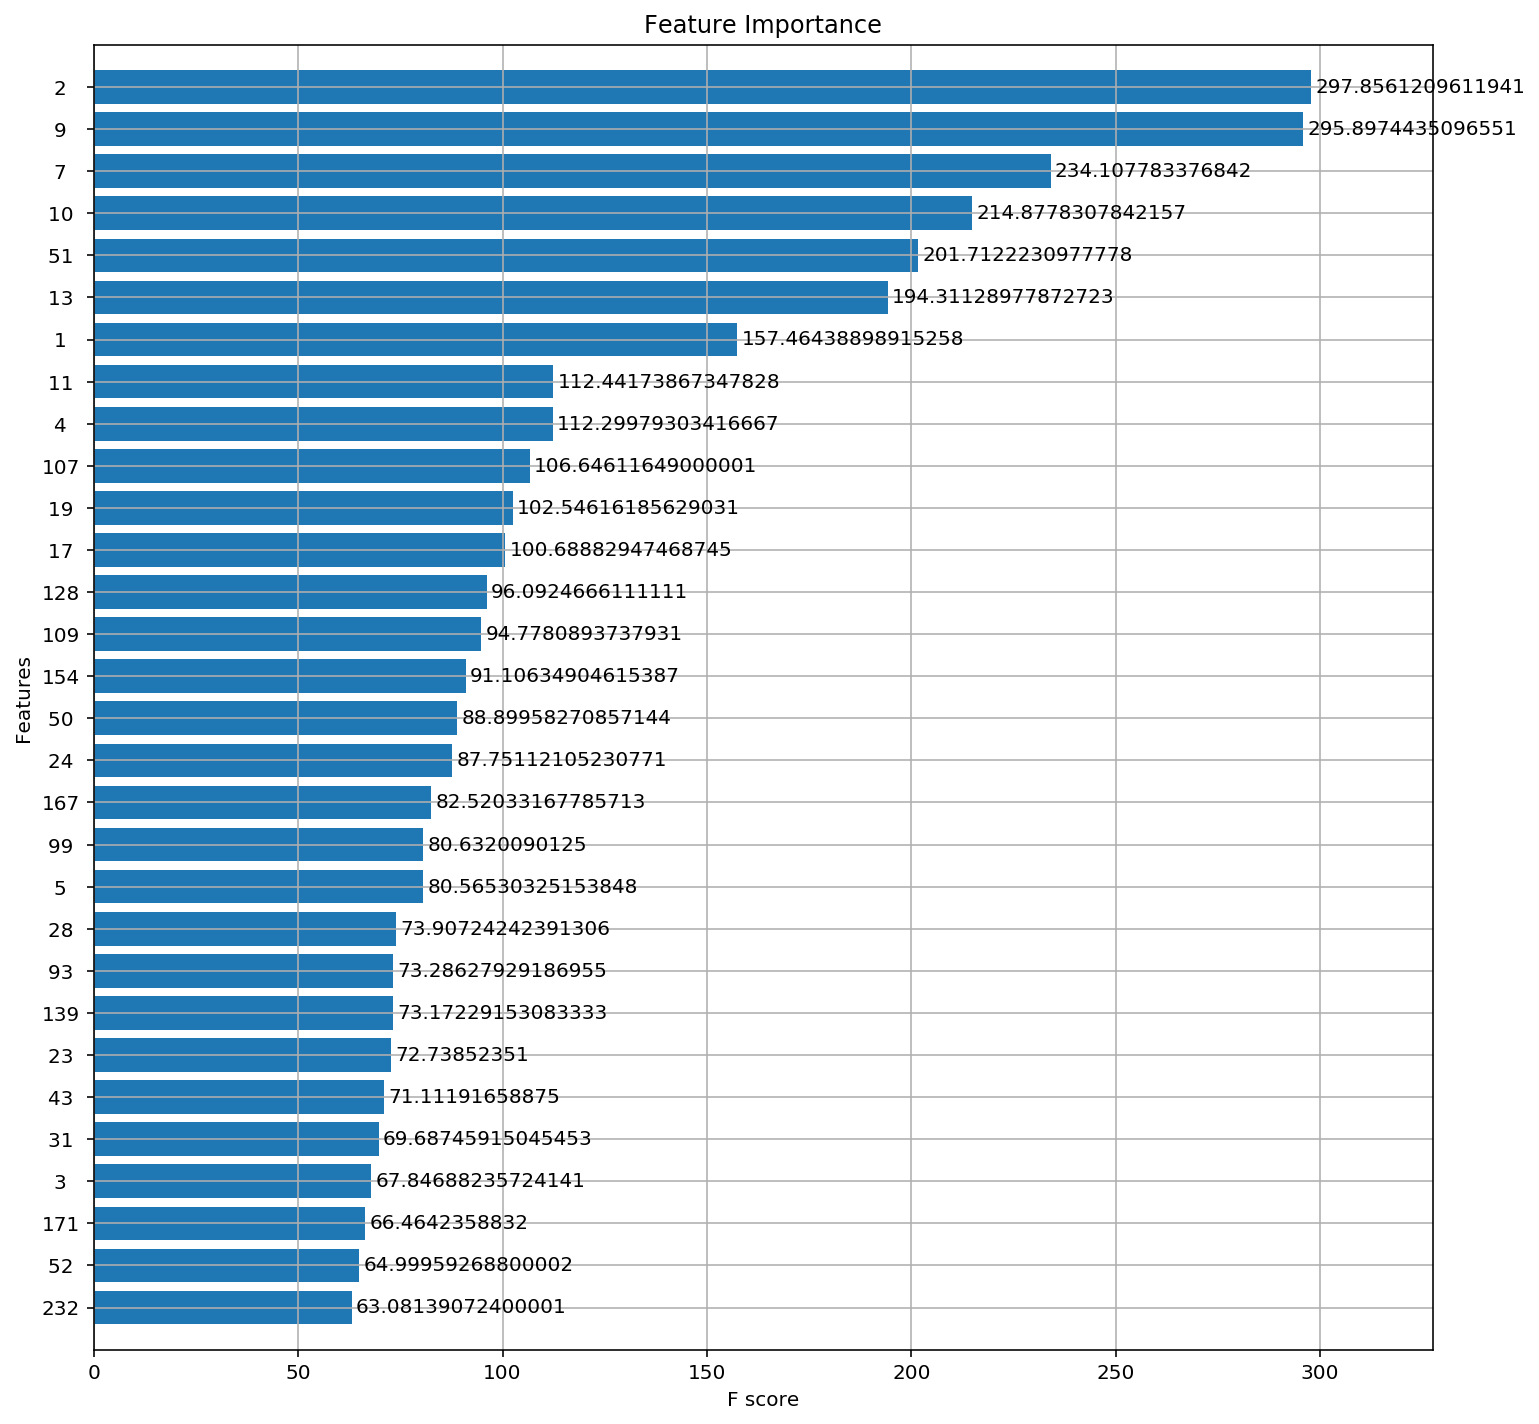

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import xgboost

fig, ax = plt.subplots(figsize=(12,12))
xgboost.plot_importance(xgb_estimator_restored, 
                        importance_type='gain', 
                        max_num_features=30, 
                        height=0.8, 
                        ax=ax, 
                        show_values = True)
plt.title('Feature Importance')
plt.show()

# Calculate Validation Metrics

In [ ]:
X_validation.head(5)

In [ ]:
preds_validation = xgb_estimator_restored.predict(xgboost.DMatrix(X_validation.values))

In [ ]:
import numpy as np
preds_validation_0_or_1 = np.where(preds_validation > 0.5, 1, 0)
preds_validation_0_or_1.shape

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix

print('Validation Accuracy: ', accuracy_score(y_validation, preds_validation_0_or_1))
print('Validation Precision: ', precision_score(y_validation, preds_validation_0_or_1, average=None))

In [ ]:
pd.DataFrame(preds_validation).head(5)

In [ ]:
print(classification_report(y_validation, preds_validation_0_or_1))

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm_validation = confusion_matrix(y_validation, preds_validation_0_or_1)
df_cm_validation

In [ ]:
import itertools
import numpy as np

def plot_conf_mat(cm, classes, title, cmap = plt.cm.Greens):
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="black" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

# Plot non-normalized confusion matrix
plt.figure()
fig, ax = plt.subplots(figsize=(10,5))
plot_conf_mat(df_cm_validation, classes=['Not Positive Sentiment', 'Positive Sentiment'], 
                          title='Confusion matrix')
plt.show()

In [ ]:
from sklearn import metrics

#print(metrics.f1_score(y_validation, preds_validation))

auc = round(metrics.roc_auc_score(y_validation, preds_validation_0_or_1), 4)
print('AUC is ' + repr(auc))

fpr, tpr, _ = metrics.roc_curve(y_validation, preds_validation_0_or_1)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Calculate Test Metrics

In [ ]:
X_test.head(5)

In [ ]:
preds_test = xgb_estimator_restored.predict(xgboost.DMatrix(X_test.values))


In [ ]:
import numpy as np
preds_test_0_or_1 = np.where(preds_test > 0.5, 1, 0)
preds_test_0_or_1.shape

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix

print('Test Accuracy: ', accuracy_score(y_test, preds_test_0_or_1))
print('Test Precision: ', precision_score(y_test, preds_test_0_or_1, average=None))

In [ ]:
print(classification_report(y_test, preds_test_0_or_1))

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm_test = confusion_matrix(y_test, preds_test_0_or_1)
df_cm_test

In [ ]:
import itertools
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

def plot_conf_mat(cm, classes, title, cmap = plt.cm.Greens):
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="black" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

# Plot non-normalized confusion matrix
plt.figure()
fig, ax = plt.subplots(figsize=(6,4))
plot_conf_mat(df_cm_test, classes=['Not Positive Sentiment', 'Positive Sentiment'], 
                          title='Confusion matrix')
plt.show()

In [ ]:
from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

auc = round(metrics.roc_auc_score(y_test, preds_test_0_or_1), 4)
print('AUC is ' + repr(auc))

fpr, tpr, _ = metrics.roc_curve(y_test, preds_test_0_or_1)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Predict in Notebook

Create `feature_transform_fn()` function (same used during `prepare` phase)

In [ ]:
# Use TruncatedSVD vs. PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

def feature_transform_fn(df_text, column_name, num_components):
    text_processors = Pipeline(
        steps=[
            (
                'tfidfvectorizer',
                TfidfVectorizer(
                    max_df=0.25,                                       
                    min_df=.0025,
                    analyzer='word',
                    max_features=10000
                )
            )
        ]
    )

    column_transformer = ColumnTransformer(
        transformers=[('text_processing', text_processors, df_text.columns.get_loc(column_name))]
    )

    pipeline = Pipeline(
        steps=[
            ('column_transformer', column_transformer), 
            ('dimension_reducer', TruncatedSVD(n_components=num_components)),
            ('standard_scaler', StandardScaler())
        ]
    )

    return pipeline

In [ ]:
# $S3_BUCKET/feature-store/amazon-reviews/scrubbed-raw-with-header

prefix_raw = 'feature-store/amazon-reviews/csv/scrubbed-raw-with-header/test'

scrubbed_raw_path = './{}'.format(prefix_raw)

import os
os.makedirs(prefix_raw, exist_ok=True)

scrubbed_raw_s3_uri = 's3://{}/{}'.format(bucket, prefix_raw)

In [ ]:
!aws s3 cp --recursive $scrubbed_raw_s3_uri $scrubbed_raw_path

In [ ]:
X_raw, y_raw = load_dataset(path=scrubbed_raw_path, sep=',', header=0)
X_raw.head(5)

In [ ]:
y_raw.head(5)

In [ ]:
np_tfidf = feature_transform_fn(df_text=X_raw, column_name='review_body', num_components=300).fit_transform(X_raw)
df_tfidf = pd.DataFrame(np_tfidf)
df_tfidf.shape

In [ ]:
df_tfidf.head(5)

In [ ]:
X_raw.head(5)

In [ ]:
y_raw.head(5)

In [ ]:
preds_raw = xgb_estimator_restored.predict(xgboost.DMatrix(df_tfidf.values))
df_preds_raw = pd.DataFrame(preds_raw)
df_preds_raw.head(5)

In [ ]:
import numpy as np
preds_raw_0_or_1 = np.where(preds_raw > 0.5, 1, 0)
preds_raw_0_or_1.shape

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix

print('Test Accuracy: ', accuracy_score(y_raw, preds_raw_0_or_1))
print('Test Precision: ', precision_score(y_raw, preds_raw_0_or_1, average=None))

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm_raw = confusion_matrix(y_raw, preds_raw_0_or_1)
df_cm_raw

In [ ]:
import itertools

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

def plot_conf_mat(cm, classes, title, cmap = plt.cm.Greens):
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="black" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

# Plot non-normalized confusion matrix
plt.figure()
fig, ax = plt.subplots(figsize=(6,4))
plot_conf_mat(df_cm_raw, classes=['Not Positive Sentiment', 'Positive Sentiment'], 
                          title='Confusion matrix')
plt.show()

In [ ]:
from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

auc = round(metrics.roc_auc_score(y_raw, preds_raw_0_or_1), 4)
print('AUC is ' + repr(auc))

fpr, tpr, _ = metrics.roc_curve(y_raw, preds_raw_0_or_1)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()